## Integrated CA 2

### Modules
### Data Preparation
### Statistics
### Machine Learning

### Contents
### 1. Introduction
### 2. Business Understanding
### 3. Data Understanding
### 4. Data Preparation

## 1. Introduction

Introduction...

#### Libraries

In [1]:
import pandas as pd


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statistics as stats
from scipy import stats
#from scipy.stats import shapiro

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import missingno as msno



import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Employee_Attrition.csv")

#### Some functions used

In [3]:
### This class could still take more methods and be expanded.
class BaselineModelEvaluator():
    # initialisation
    def __init__(self, df, y, y2=None):
        self.counter = 1
        # don't overwrite original
        self.df = df.copy()
        self.X = None
        self.y = y
        self.y2 = y2
        self.tar=None
        self.tar_string = None        
        
        # these will be assigned later
        self.encoder = LabelEncoder()
        self.imputer=imputer=SimpleImputer(strategy='mean')
        self.model=LinearRegression()
        
        self.drop_second=False
   
    def pipeline(self):
        # train test split
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.tar, test_size=0.2, random_state=659)
        
        # pipeline
        pipe = Pipeline([('imputer', self.imputer), ('model', self.model)])

        # impute in sequence
        X_train_imputed = pipe.named_steps['imputer'].fit_transform(X_train)
        X_test_imputed = pipe.named_steps['imputer'].transform(X_test)
        
        # Fit the model
        pipe.fit(X_train_imputed, y_train)
       
        # predictions
        y_pred = pipe.predict(X_test_imputed)

        # metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Print evaluation metrics
        print(f"{self.counter}. Baseline model for predicting {self.tar_string}")
        self.counter += 1
        print(f"Using: {self.model}, {self.imputer}, {self.encoder}")
        print(f"Drop second target = {self.drop_second}") # rephrase this
        print(f"Mean Squared Error (MSE): {mse}")
        print(f"R-squared (R2): {r2}")
        print("\n")
       
        
    def encode_categories(self):
        # encoding categories
        categorical_columns = self.df.select_dtypes(include=['object']).columns.tolist()
        for column in categorical_columns:
            self.df[column] = self.encoder.fit_transform(self.df[column])

    def impute_targets(self):     
        # impute y with mean
        self.df[self.y] = self.df[self.y].fillna(self.df[self.y].mean())
        if self.y2:
            self.df[self.y2] = self.df[self.y2].fillna(self.df[self.y2].mean())
            
    def model_y(self):
        # model target
        self.tar = self.df[self.y]
        self.tar_string = self.y
        self.X = self.df.drop(self.y, axis=1)
        if self.drop_second == True:
            self.X = self.X.drop(self.y2, axis=1)
        self.pipeline()
        self.drop_second=False
    
    def model_y2(self):
        # model secondary target if there is one
        if self.y2 is not None:
            self.tar = self.df[self.y2]
            self.tar_string = self.y2
            self.X = self.df.drop(self.y2, axis=1)
            if self.drop_second == True:
                self.X = self.X.drop(self.y, axis=1)
            self.pipeline()
            self.drop_second = False
        else:
            pass
        
    def set_model(self, model=None, imputer=None, encoder=None):
        # set modelling attributes
        # can add more stuff here
        if encoder is not None:
            self.encoder = encoder
        if imputer is not None:
            self.imputer = imputer
        if model is not None:
            self.model = model


    def baseline_models(self, title="Baseline models report\n"):
        print(title)
        # this method to run the different pipelines and parts of above model moved to init
        self.encode_categories()
        self.impute_targets()
        self.model_y()
        self.drop_second=True
        self.model_y()
        if self.y2 is not None:
            self.model_y2()
            self.drop_second=True
            self.model_y2()        

In [4]:
# histogram
def histogram(df, var, x_size=4, y_size=4, x_label="Values", y_label="Frequency",
              bins=10, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(x_size, y_size))
    
    sns.histplot(data=df, x=var, kde=False, bins=bins, color='green', ax=ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    title = f"Histogram of {var}"
    ax.set_title(title)
    
    if ax is None:
        plt.show()

In [5]:
# Boxplot
def boxplot(df, var, x_size=4, y_size=4, x_label="Values", y_label="Frequency", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(x_size, y_size))

    sns.boxplot(data=df, x=var, ax=ax, color='skyblue')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    title = f"Boxplot of {var}"
    ax.set_title(title)
    
    if ax is None:
        plt.show()

In [272]:
# printing statistical information out beside graph for analysis
# could possibly leave out boxplot from this and look at box plots together

def numerical_explore(df, var, bins=15):
    # 15 as default bins in histogram function
    
    # copy dataframe
    df1 = df.copy()

    # removing null values for graphing
    df1.dropna(subset=[var], inplace=True)
    # check for null values
    if df1[var].isnull().sum() > 0 : print(f"{var} contains null values.")

    fig, axs = plt.subplots(1,3, figsize=(13, 5))

    # title
    fig.suptitle(f"Exploration of {var}", fontsize=16)

    # histogram
    axs[0] = histogram(df1, var, bins=bins, ax=axs[0])

    # shapiro-wilk test
    stat, p_value = stats.shapiro(df1[var])
    if p_value > 0.05:
        gaus ="Sample looks Gaussian (fail to reject H0)"
    else:
        gaus = f"""Sample does not look Gaussian (reject H0)
        p-value of {p_value}"""

    # generate statistical information
    statistics = f"""Statistical Information for {var}
    
    {df1[var].describe()}
    
    Range : {(df1[var].max()-df1[var].min())}
    IQR : {(df1[var].quantile(0.75)-df1[var].quantile(0.25))}
    
    Skew : {stats.skew(df1[var])}
    
    {gaus}"""
    
    
    # statistical information axis
    axs[1].text(0,1, statistics, ha="left", va="top")
    axs[1].axis("off")

    # boxplot
    axs[2] = boxplot(df1, var, ax=axs[2])
    
    
    plt.tight_layout() 
    plt.show()

## 2. Business Understanding

The main task of this project is to analyse the 

## 3. Data Understanding

In [6]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41.920786,Yes,Travel_Rarely,990.110009,Sales,1.016716,1.770313,Life Sciences,1.033298,1.054148,...,1.012832,95.612654,0.000000,8.063833,0.000000,1.052104,5.795945,3.993896,0.000000,4.594972
1,51.589037,No,Travel_Frequently,276.776030,Research & Development,NaN,1.035333,Life Sciences,0.944859,2.107031,...,4.312008,85.370868,1.104642,8.965059,3.264952,2.526470,10.070232,7.937505,1.032295,5.901207
2,33.131540,Yes,Travel_Rarely,1204.158501,Research & Development,2.198662,2.118801,Other,0.810809,4.008125,...,2.332558,76.248084,0.000000,8.427238,3.004521,2.924784,0.000000,0.000000,0.000000,0.000000
3,34.707073,No,Travel_Frequently,1352.752432,Sales,2.937851,3.670674,Life Sciences,0.822976,4.587269,...,3.029591,75.888697,0.000000,7.662606,2.856001,3.117053,8.435324,5.563667,2.845429,0.000000
4,24.790188,No,Travel_Rarely,485.053333,Research & Development,1.988953,1.120496,Medical,NaN,7.228740,...,NaN,72.670937,0.953012,6.241733,2.814719,3.112317,2.040124,1.970786,2.495949,2.219353


In [7]:
df.shape

(1470, 35)

In [8]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,...,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000
mean,36.635268,802.030050,9.091097,2.923447,0.999325,1026.679166,2.726443,65.647722,2.743028,2.058270,...,2.720431,80.241313,0.814757,11.426152,2.811756,2.762825,6.933624,4.233363,2.160710,4.117695
std,9.882161,414.031025,8.177870,1.072203,0.099656,610.480802,1.129679,21.469709,0.765568,1.127018,...,1.115959,8.022535,0.863076,8.075870,1.329044,0.761802,6.046798,3.658111,3.221481,3.594053
min,14.544608,86.828045,0.750112,0.770362,0.628985,1.054148,0.759655,23.855272,0.722008,0.715172,...,0.720696,53.793059,0.000000,0.000000,0.000000,0.799138,0.000000,0.000000,0.000000,0.000000
25%,29.624982,456.479553,2.147069,2.122706,0.931146,501.854842,1.894818,47.701897,2.177638,1.045228,...,1.909010,74.882946,0.000000,5.953221,1.967328,2.193390,2.673269,1.824392,0.000000,1.687177
50%,34.951950,782.958705,6.920808,3.015658,0.998949,1022.025017,2.887313,64.934490,2.859143,1.936150,...,2.891235,80.351400,0.913651,9.306742,2.690934,2.899807,5.422160,2.968874,0.967140,2.939240
75%,42.748741,1130.577949,13.584900,3.700560,1.067371,1533.811096,3.676600,83.038355,3.179128,2.609707,...,3.639961,85.664169,1.082523,15.324548,3.366949,3.206117,9.238005,7.052591,2.586631,6.987964
max,69.402515,1784.394456,33.684424,6.285161,1.290613,2530.919375,5.254672,123.200439,5.241968,5.942269,...,5.092280,107.378705,3.474319,47.641892,7.503201,4.856086,36.848408,19.091844,17.273662,19.976003


In [9]:
df.describe(include="object").T

,count,unique,top,freq
Attrition,1323,2,No,1065
BusinessTravel,1323,3,Travel_Rarely,890
Department,1323,3,Research & Development,824
EducationField,1323,6,Life Sciences,504
Gender,1323,2,Male,783
JobRole,1323,9,Sales Executive,281
MaritalStatus,1323,3,Married,596
Over18,1323,1,Y,1323
OverTime,1323,2,No,929


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1323 non-null   float64
 1   Attrition                 1323 non-null   object 
 2   BusinessTravel            1323 non-null   object 
 3   DailyRate                 1323 non-null   float64
 4   Department                1323 non-null   object 
 5   DistanceFromHome          1323 non-null   float64
 6   Education                 1323 non-null   float64
 7   EducationField            1323 non-null   object 
 8   EmployeeCount             1323 non-null   float64
 9   EmployeeNumber            1323 non-null   float64
 10  EnvironmentSatisfaction   1323 non-null   float64
 11  Gender                    1323 non-null   object 
 12  HourlyRate                1323 non-null   float64
 13  JobInvolvement            1323 non-null   float64
 14  JobLevel

In [11]:
df.isnull().sum()

Age                         147
Attrition                   147
BusinessTravel              147
DailyRate                   147
Department                  147
DistanceFromHome            147
Education                   147
EducationField              147
EmployeeCount               147
EmployeeNumber              147
EnvironmentSatisfaction     147
Gender                      147
HourlyRate                  147
JobInvolvement              147
JobLevel                    147
JobRole                     147
JobSatisfaction             147
MaritalStatus               147
MonthlyIncome               147
MonthlyRate                 147
NumCompaniesWorked          147
Over18                      147
OverTime                    147
PercentSalaryHike           147
PerformanceRating           147
RelationshipSatisfaction    147
StandardHours               147
StockOptionLevel            147
TotalWorkingYears           147
TrainingTimesLastYear       147
WorkLifeBalance             147
YearsAtC

In [12]:
# missing data seems like 10 random data points from each column?
df.isnull().head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False


<Axes: >

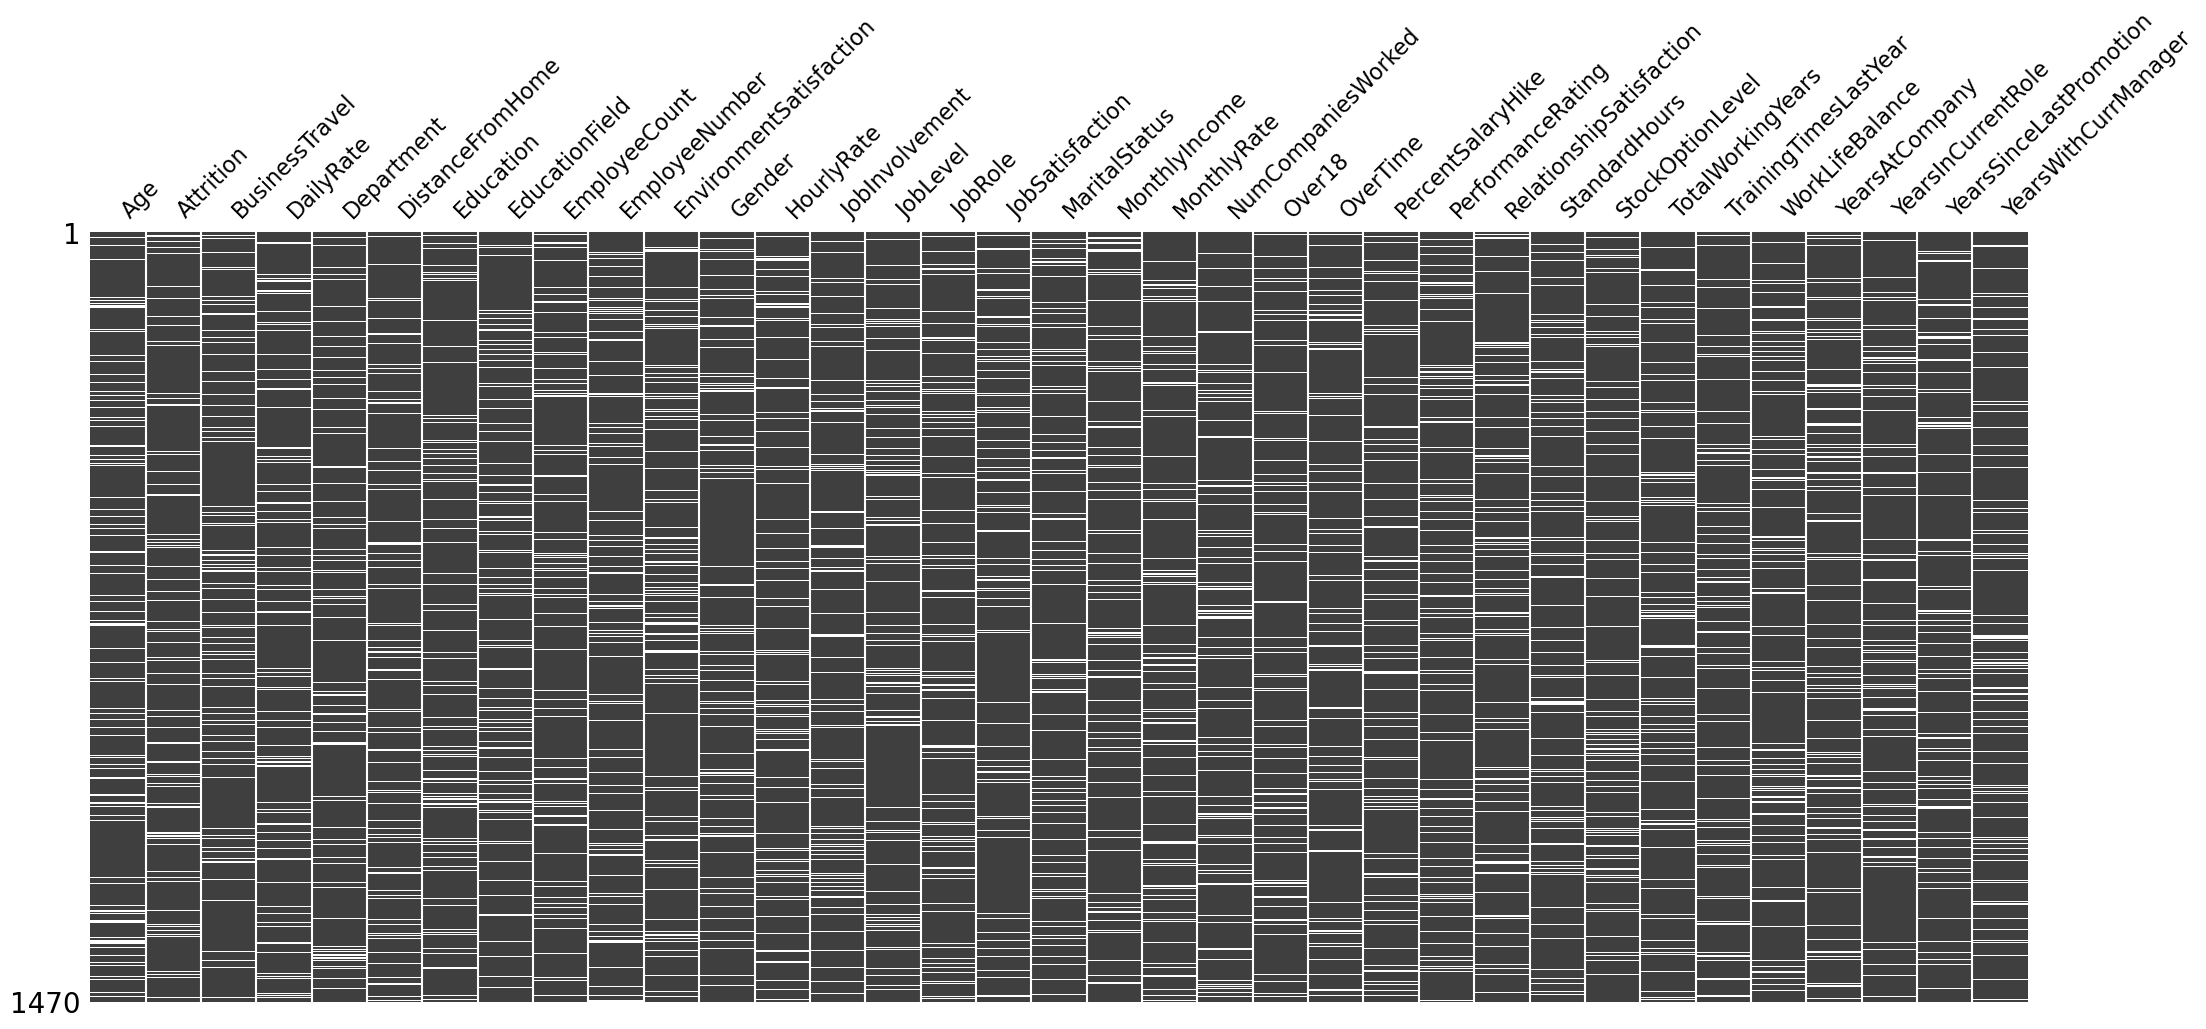

In [13]:
msno.matrix(df, sparkline=False)

#### Target variables

In [14]:
# business objectives are represented by features in the data
df[["JobSatisfaction", "PerformanceRating"]].describe()

,JobSatisfaction,PerformanceRating
count,1323.000000,1323.000000
mean,2.715272,3.149344
std,1.146786,0.476027
min,0.724192,2.116951
25%,1.846039,2.845502
50%,2.895032,3.064551
75%,3.676663,3.335525
max,5.251277,5.013371


In [15]:
df[["JobSatisfaction", "PerformanceRating"]].head()

,JobSatisfaction,PerformanceRating
0,3.397665,2.844897
1,1.584059,4.120281
2,3.301009,2.781168
3,3.220844,2.769576
4,1.697330,3.282183


In [16]:
# not sure if this works
def whole_numbers(df, var):
    df1 = df[(df[var] == 5) | (df[var] == 4) | (df[var] == 3) 
            | (df[var] == 2) | (df[var] == 1) | (df[var] == 0)]
    print(f"Number of target feature '{var}' as whole number: {len(df1)}")

def target_explore(df, var1, var2):
    whole_numbers(df, var1)
    whole_numbers(df, var2)

target_explore(df, "JobSatisfaction", "PerformanceRating")

Number of target feature 'JobSatisfaction' as whole number: 0
Number of target feature 'PerformanceRating' as whole number: 0


In [17]:
# target variables

In [18]:
#df["PerformanceRating"] = df["PerformanceRating"].fillna(df["PerformanceRating"].mean())

In [19]:
X1 = df["JobSatisfaction"]
X2 = df["PerformanceRating"]

In [20]:
#We can perform the test using those variables

t_test = stats.ttest_ind(X1, X2, equal_var = False)
display(t_test)

TtestResult(statistic=nan, pvalue=nan, df=nan)

#### Independent Variables

In [21]:
# features are investigated here
print("Independent Features Number: {}".format(len(df.columns)-2))
print("Numerical: {}".format(len(df.select_dtypes(include='number').columns)-2))
print("Categories: {}".format(len(df.select_dtypes(include='object').columns)))

Independent Features Number: 33
Numerical: 24
Categories: 9


In [22]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

#### Independent Variables: Age

In [143]:
# age is a sample from a normal distribution
# 10% missing values
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

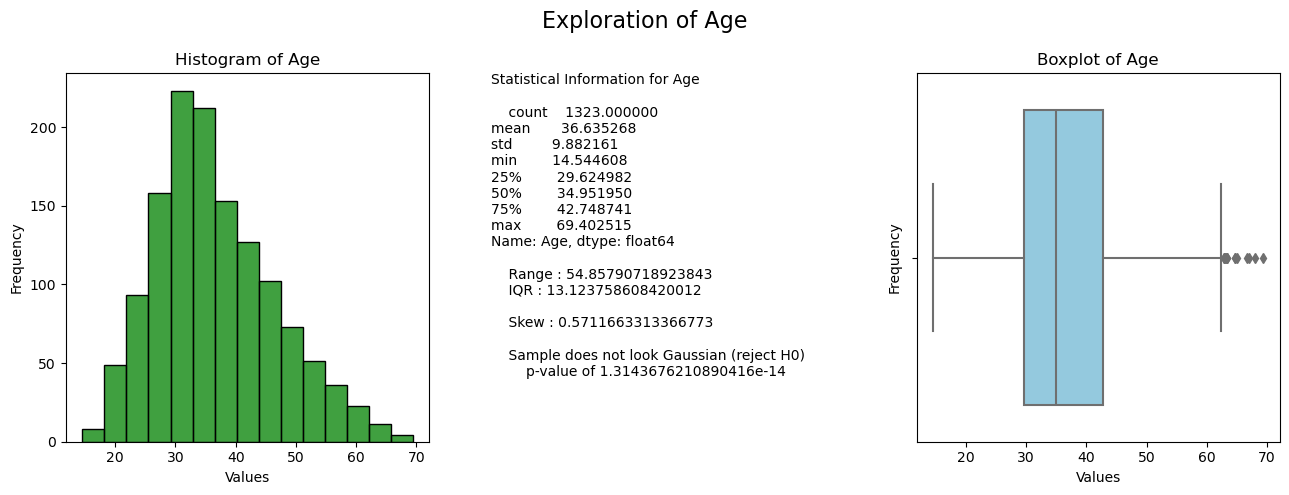

In [256]:
# would expect age to be gaussian if it was a sample of the whole population
# but it isn't, it is a sample of the working population that the company employed
# a subset of the whole population; (working age) and (currently or previously employed)
numerical_explore(df, "Age")

In [27]:
df1 = df[df["Age"] < 18]
df1[["Age", "Over18"]].head(50)

,Age,Over18
206,16.057972,NaN
498,16.792547,Y
828,16.741273,Y
853,16.789596,Y
972,14.544608,Y
1153,16.840129,Y
1197,17.109549,Y


In [28]:
df1 = df[df["Over18"] == "N"]
df1[["Age", "Over18"]].head(50)

,Age,Over18


In [29]:
df.Over18.value_counts()

Over18
Y    1323
Name: count, dtype: int64

#### Independent Variables: Attrition

In [30]:
# Attrition is if the employee has left the company or not
# Attrition is an unbalanced binary category

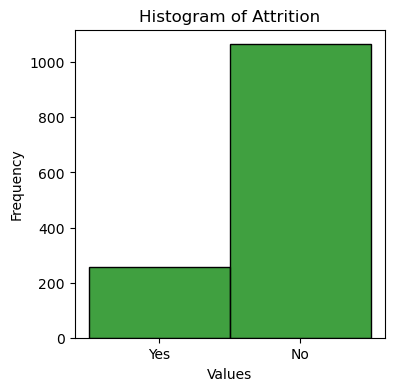

In [31]:

histogram(df, "Attrition",)

In [32]:
df.Attrition.value_counts()

Attrition
No     1065
Yes     258
Name: count, dtype: int64

#### Independent Variables: Business Travel

In [33]:
# frequency of business travel

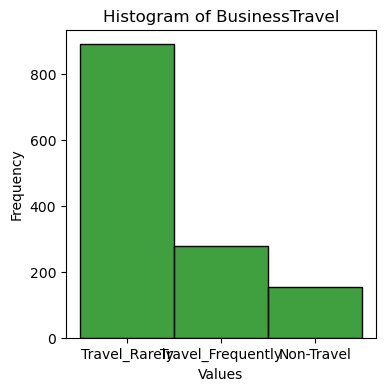

In [34]:
#
histogram(df, "BusinessTravel",)

In [35]:
df.BusinessTravel.value_counts()

BusinessTravel
Travel_Rarely        890
Travel_Frequently    279
Non-Travel           154
Name: count, dtype: int64

#### Independent Variable: DailyRate

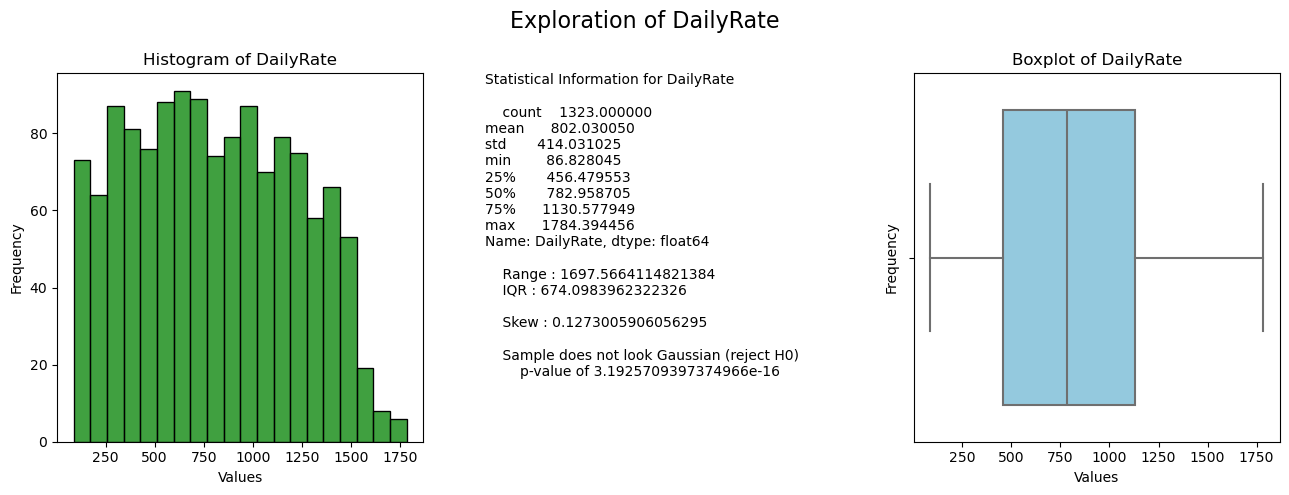

In [280]:
# more bins to bring out the shape slightly
numerical_explore(df, "DailyRate", bins=20)

#### Independent Variable: Department

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

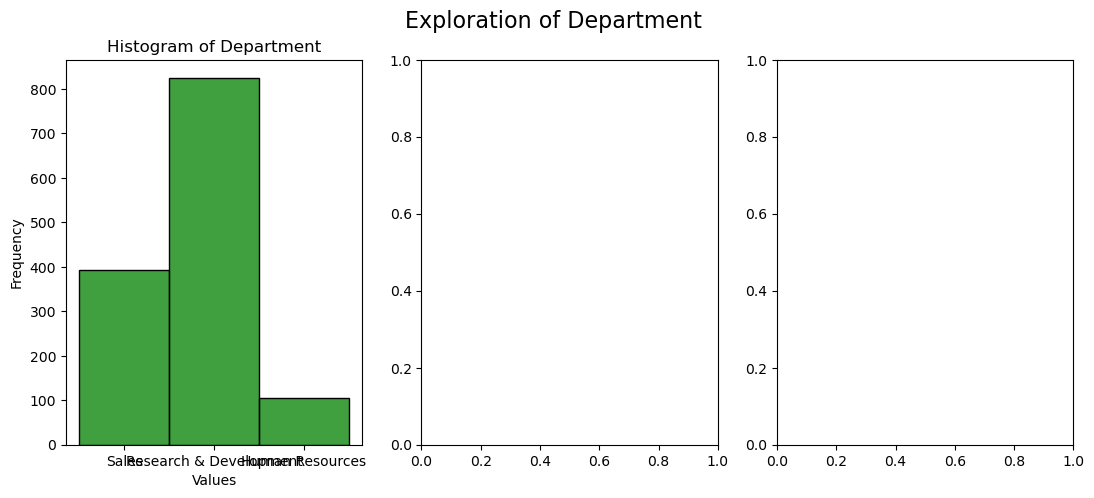

In [281]:
numerical_explore(df, "Department", bins=20)

In [72]:
var = "YearsWithCurrManager"
df1 = df[var]
df1.dropna(inplace=True)
df1

0       4.594972
1       5.901207
2       0.000000
3       0.000000
4       2.219353
          ...   
1463    7.246015
1464    0.000000
1466    6.756705
1467    3.271091
1469    2.025939
Name: YearsWithCurrManager, Length: 1323, dtype: float64

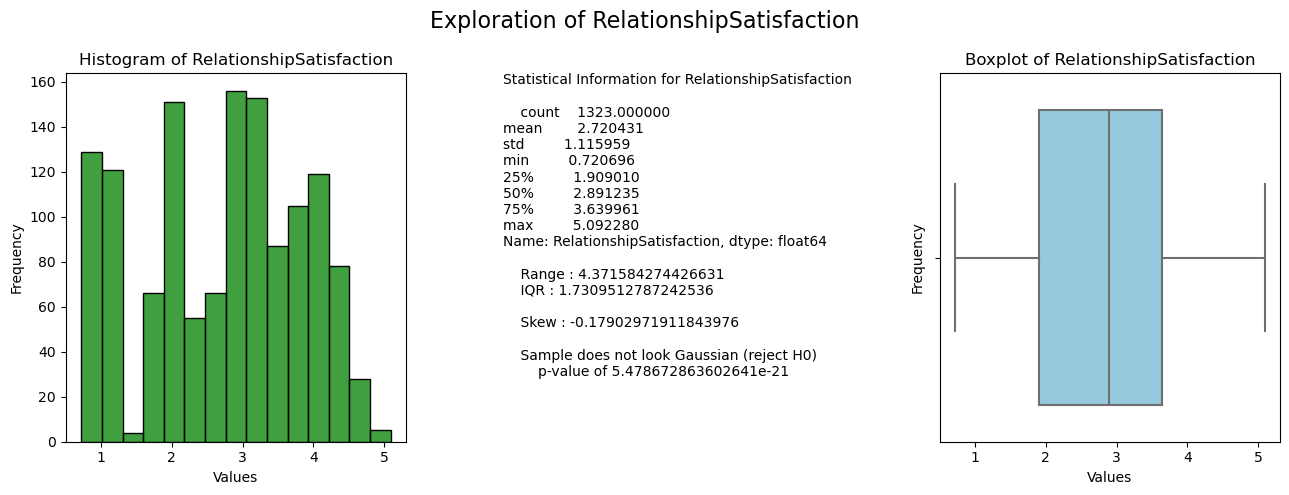

In [284]:
# more bins to bring out the shape slightly
numerical_explore(df, "RelationshipSatisfaction")

#### Correlations

In [36]:
correlation_matrix = df.select_dtypes(include=['number'])
correlation_matrix.corr().shape

(26, 26)

In [37]:
# looking through the numbers is unintuitive
correlation_matrix.corr()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,0.003115,-0.004483,0.218413,-0.012545,-0.003796,-0.011972,0.027241,0.023650,0.467031,...,0.025094,0.002155,0.042739,0.625620,-0.021116,-0.035865,0.273534,0.179098,0.183958,0.183590
DailyRate,0.003115,1.000000,-0.004227,-0.012328,0.009567,-0.050564,0.019894,0.031691,0.051141,-0.013380,...,0.019652,-0.040108,0.007044,0.013766,-0.009000,-0.035260,-0.038210,0.007122,-0.022840,-0.039930
DistanceFromHome,-0.004483,-0.004227,1.000000,0.012109,0.005865,0.035067,-0.030355,0.026033,-0.005980,0.023336,...,0.024771,-0.002562,0.039794,0.004308,-0.047087,-0.017814,0.023940,0.020311,-0.005743,0.033454
Education,0.218413,-0.012328,0.012109,1.000000,-0.037297,0.035267,0.007502,0.003187,0.033630,0.106218,...,-0.019207,0.010267,0.008528,0.147655,-0.034722,-0.004356,0.075283,0.072572,0.050648,0.065608
EmployeeCount,-0.012545,0.009567,0.005865,-0.037297,1.000000,0.063013,0.026024,0.056652,-0.039578,0.004059,...,0.015579,-0.003399,-0.038158,0.002776,-0.054455,-0.004015,0.018562,0.016204,-0.004410,-0.033018
EmployeeNumber,-0.003796,-0.050564,0.035067,0.035267,0.063013,1.000000,0.040412,0.003557,-0.016547,-0.004218,...,-0.072664,0.000358,0.063318,-0.019994,-0.006759,0.020873,-0.002520,-0.017335,-0.008418,-0.020842
EnvironmentSatisfaction,-0.011972,0.019894,-0.030355,0.007502,0.026024,0.040412,1.000000,-0.037906,-0.022821,0.007245,...,0.025902,-0.018980,-0.001693,-0.012346,-0.029385,0.037832,-0.021525,-0.001210,-0.000513,-0.051181
HourlyRate,0.027241,0.031691,0.026033,0.003187,0.056652,0.003557,-0.037906,1.000000,0.031025,-0.010295,...,0.003273,-0.017825,0.031599,0.047688,-0.030968,-0.016889,0.037367,-0.005881,0.008520,0.014796
JobInvolvement,0.023650,0.051141,-0.005980,0.033630,-0.039578,-0.016547,-0.022821,0.031025,1.000000,-0.008527,...,0.003356,0.003931,0.008476,0.012578,-0.033358,-0.023270,0.000706,0.032181,0.022490,0.046256
JobLevel,0.467031,-0.013380,0.023336,0.106218,0.004059,-0.004218,0.007245,-0.010295,-0.008527,1.000000,...,0.023036,0.043070,0.017891,0.756814,-0.038575,0.041841,0.494295,0.365519,0.349137,0.357980


correlation shape: (26, 26)


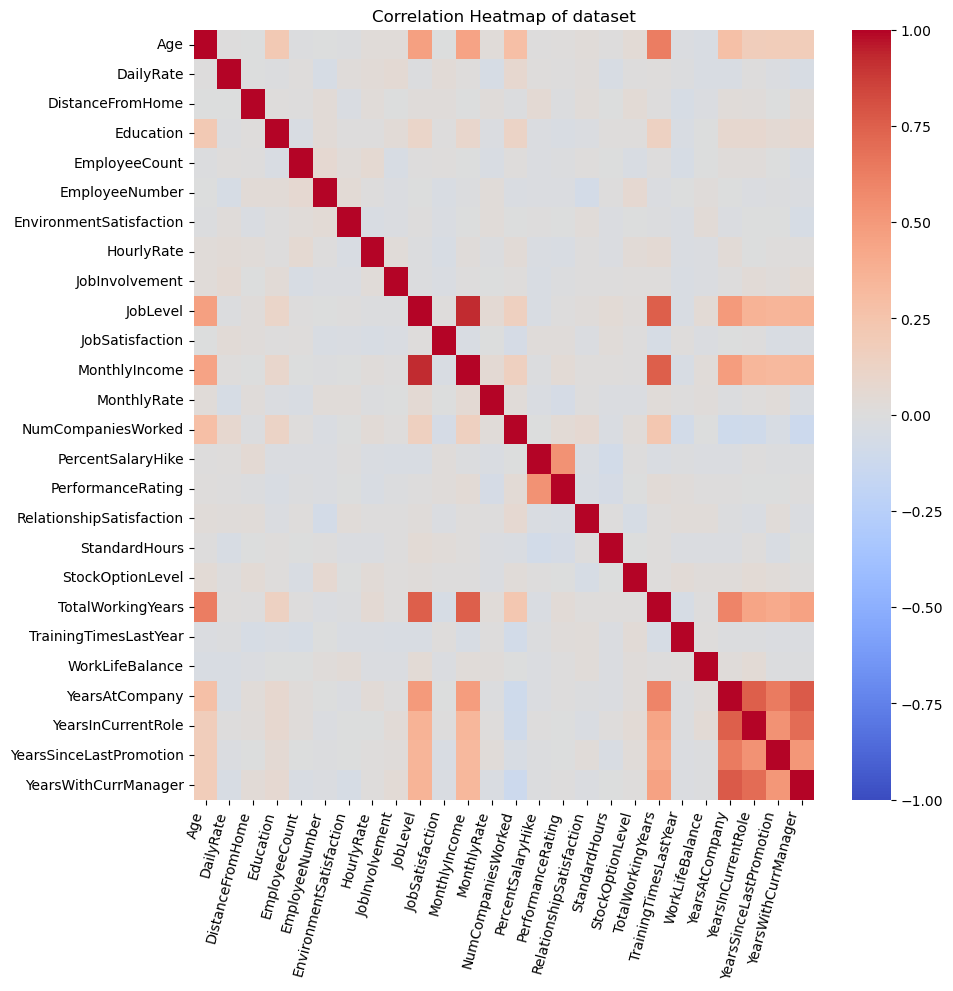

In [38]:
# correlation is easier to view in a larger number of features like this
# correlation matrix
correlation_matrix = df.select_dtypes(include=['number']).corr()
print(f"correlation shape: {correlation_matrix.shape}")

# correlation heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.xticks(rotation=75, ha='right')
plt.title('Correlation Heatmap of dataset')
plt.show()

In [39]:
# from above, monthly income and job level are highly correlated
df.MonthlyIncome.corr(df.JobLevel)

0.9235098140677838

In [40]:
# total working years is correlated with some features too
print("Correlations of TotalWorkingYears")
print("vs. JobLevel: ", df.TotalWorkingYears.corr(df.JobLevel))
print("vs. MonthlyIncome: ", df.TotalWorkingYears.corr(df.MonthlyIncome))
print("vs. YearsAtCompany: ", df.TotalWorkingYears.corr(df.YearsAtCompany))

Correlations of TotalWorkingYears
vs. JobLevel:  0.7568136270833515
vs. MonthlyIncome:  0.757637022403104
vs. YearsAtCompany:  0.593883740319838


In [41]:
# the last 4 columns are correlated together
# they are all related to years working
df.iloc[:,-4:].corr()

,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
YearsAtCompany,1.000000,0.753423,0.639672,0.767222
YearsInCurrentRole,0.753423,1.000000,0.532027,0.702790
YearsSinceLastPromotion,0.639672,0.532027,1.000000,0.509521
YearsWithCurrManager,0.767222,0.702790,0.509521,1.000000


#### Baseline model

In [42]:
# baseline model
# impute missing data (which strategies to use)
# encode categories vs. drop
# model data

In [43]:
# baseline model with mean imputation
# create class object
baseline = BaselineModelEvaluator(df, "PerformanceRating", "JobSatisfaction")
baseline.baseline_models()

Baseline models report

1. Baseline model for predicting PerformanceRating
Using: LinearRegression(), SimpleImputer(), LabelEncoder()
Drop second target = False
Mean Squared Error (MSE): 0.16172461471979546
R-squared (R2): 0.10528648346962755


2. Baseline model for predicting PerformanceRating
Using: LinearRegression(), SimpleImputer(), LabelEncoder()
Drop second target = True
Mean Squared Error (MSE): 0.16182123334571688
R-squared (R2): 0.10475195759853317


3. Baseline model for predicting JobSatisfaction
Using: LinearRegression(), SimpleImputer(), LabelEncoder()
Drop second target = False
Mean Squared Error (MSE): 1.2782959890439207
R-squared (R2): -0.01889457500939362


4. Baseline model for predicting JobSatisfaction
Using: LinearRegression(), SimpleImputer(), LabelEncoder()
Drop second target = True
Mean Squared Error (MSE): 1.2790067145773945
R-squared (R2): -0.01946107478455028




## 4. Data Preparation

In [44]:
# we want to investigate data preparation on model influence
# this can be done with pipelines

#### qq plot - for refrence

In [45]:
df1 = df.dropna(subset=['JobSatisfaction'])
df1.JobSatisfaction

0       3.397665
1       1.584059
2       3.301009
3       3.220844
4       1.697330
          ...   
1463    0.908844
1464    3.541107
1465    4.169226
1467    2.152039
1469    2.875309
Name: JobSatisfaction, Length: 1323, dtype: float64

<Figure size 640x480 with 0 Axes>

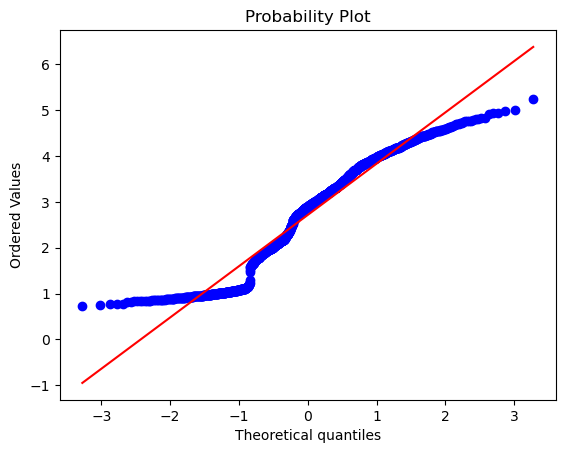

<Figure size 640x480 with 0 Axes>

In [46]:
# check normality with qq plot
from scipy import stats

stats.probplot(df1.JobSatisfaction, plot=plt)
plt.figure()

In [47]:
df1.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1188.000000,1192.000000,1186.000000,1194.000000,1192.000000,1197.000000,1192.000000,1193.000000,1189.000000,1187.000000,...,1196.000000,1194.000000,1189.000000,1192.000000,1196.000000,1189.000000,1186.000000,1192.000000,1184.000000,1191.000000
mean,36.495838,805.494793,9.201445,2.936375,0.998408,1025.469279,2.721505,65.442673,2.746211,2.053566,...,2.734805,80.163519,0.812520,11.337150,2.816025,2.762884,6.926224,4.222388,2.175405,4.106237
std,9.809512,411.657883,8.287617,1.064895,0.099774,608.942998,1.124422,21.782457,0.748622,1.116449,...,1.109585,8.019629,0.862939,7.923209,1.323819,0.759469,6.054633,3.657937,3.174244,3.585299
min,14.544608,86.828045,0.750112,0.770362,0.628985,1.054148,0.759655,23.855272,0.722008,0.715172,...,0.720696,53.793059,0.000000,0.000000,0.000000,0.810358,0.000000,0.000000,0.000000,0.000000
25%,29.581763,462.477699,2.129660,2.137080,0.929847,502.369064,1.897783,46.961901,2.189484,1.047910,...,1.928418,74.714348,0.000000,5.959950,1.973390,2.203877,2.637693,1.821684,0.000000,1.687177
50%,34.927766,785.720858,6.987912,3.025711,0.998455,1023.762026,2.893943,64.571598,2.865495,1.936892,...,2.893936,80.225148,0.915511,9.285336,2.703719,2.907097,5.375840,2.928641,0.980509,2.923084
75%,42.414941,1134.970022,13.730572,3.699283,1.065868,1530.600000,3.655941,83.071843,3.169189,2.603497,...,3.653593,85.654239,1.084016,15.351460,3.361096,3.203103,9.153924,7.048819,2.667359,6.978546
max,69.402515,1784.394456,33.684424,6.285161,1.273037,2530.919375,5.254672,123.200439,5.026636,5.942269,...,5.092280,107.378705,3.474319,43.621947,7.503201,4.856086,36.848408,19.091844,17.273662,19.976003


In [48]:
df1.describe(include="object")

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
count,1187,1187,1188,1186,1191,1189,1185,1189,1197
unique,2,3,3,6,2,9,3,1,2
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,No
freq,952,799,727,447,696,260,533,1189,838


In [49]:
df1.BusinessTravel.value_counts()

BusinessTravel
Travel_Rarely        799
Travel_Frequently    254
Non-Travel           134
Name: count, dtype: int64

In [50]:
stats.shapiro(df1.JobSatisfaction)

ShapiroResult(statistic=0.9469164609909058, pvalue=2.0280033122195895e-21)

In [51]:
# H0: data comes from normal distribution
# H1: data does not come from normal distribution

# test not performed
stats.shapiro(df1.JobSatisfaction[df["BusinessTravel"]=="Travel_Rarely"])

ShapiroResult(statistic=0.9444419145584106, pvalue=9.777387998684584e-17)

In [52]:
df.JobSatisfaction.shape

(1470,)

In [53]:
rarely = df.JobSatisfaction[df["BusinessTravel"]=="Travel_Rarely"]
frequently = df.JobSatisfaction[df["BusinessTravel"]=="Travel_Frequently"]
nontravel = df.JobSatisfaction[df["BusinessTravel"]=="Non-Travel"]

In [54]:
#H0: equal variances
#H1: non equal variances

from scipy.stats import levene

levene(rarely, frequently, nontravel, center = "mean")

LeveneResult(statistic=nan, pvalue=nan)

In [55]:
# normality confirmed so can perform anova

# H0: mu is equal amongst groups
# H1: at least one mu is different

from statsmodels.formula.api import ols
import statsmodels.api as sm

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
# model
model = ols("JobSatisfaction~BusinessTravel", data=df).fit()

# anova linear model
aov = sm.stats.anova_lm(model, type=2)
print(aov)

# accept H0 in this situation